In [71]:
import googlemaps 
import gmaps
import csv
import pickle 
import time
import os

from datetime import datetime
from googleplaces import GooglePlaces, types, lang
from math import sin, cos, sqrt, atan2, radians
# Anything marked "NEW" is included for generating tf-idf matrices
# need to include googlemaps in requirements
# need to include gmaps in requirements


In [650]:
def computeDistanceLatLong(lat1, lon1, lat2, lon2):
	"""
	Computes distance between two locations using lat long 

	"""
	# approximate radius of earth in km
	R = 6373.0

	lat1 = radians(lat1)
	lon1 = radians(lon1)
	lat2 = radians(lat2)
	lon2 = radians(lon2)

	dlon = lon2 - lon1
	dlat = lat2 - lat1

	a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
	c = 2 * atan2(sqrt(a), sqrt(1 - a))

	distance = R * c

	return distance

In [80]:
print(len(review_ids_to_reviews))

5147


In [ ]:
###### START OF NLTK/SVD STUFF ###########

In [81]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .7,
                            min_df = 5)
my_matrix = vectorizer.fit_transform(all_reviews).transpose()

In [82]:
print(my_matrix.shape)

(3281, 5147)


In [83]:
from scipy.sparse.linalg import svds
u, s, v_trans = svds(my_matrix, k=50)

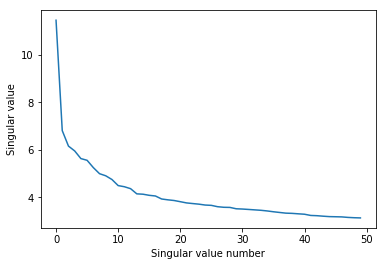

In [84]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [85]:
words_compressed, _, docs_compressed = svds(my_matrix, k=10)
docs_compressed = docs_compressed.transpose()

In [86]:
print(words_compressed.shape)
print(docs_compressed.shape)

(3281, 10)
(5147, 10)


In [87]:
word_to_index = vectorizer.vocabulary_
index_to_word = {word_to_index[t]:t for t in word_to_index}
print(words_compressed.shape)

(3281, 10)


In [88]:
#row normalize
from sklearn.preprocessing import normalize
words_compressed = normalize(words_compressed, axis = 1)

In [89]:
def closest_words(word_in, k = 10): #k = 338):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_compressed.dot(words_compressed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

In [90]:
# Gives you the top 10 words similar to kayak
closest_words("adventure")

'Not in vocab.'

In [93]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet 
# This is how you get synonyms
syns = wordnet.synsets("aquarium") 
# Seems like this could be useful
print(syns[0])
print(syns[0].definition().split())
print(nltk.pos_tag(syns[0].definition().split()))

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...


Synset('aquarium.n.01')
['a', 'tank', 'or', 'pool', 'or', 'bowl', 'filled', 'with', 'water', 'for', 'keeping', 'live', 'fish', 'and', 'underwater', 'animals']
[('a', 'DT'), ('tank', 'NN'), ('or', 'CC'), ('pool', 'NN'), ('or', 'CC'), ('bowl', 'NN'), ('filled', 'VBN'), ('with', 'IN'), ('water', 'NN'), ('for', 'IN'), ('keeping', 'VBG'), ('live', 'JJ'), ('fish', 'NN'), ('and', 'CC'), ('underwater', 'NN'), ('animals', 'NNS')]


[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
###### END OF NLTK/SVD STUFF ###########

In [649]:
###### START OF GENERATING SEARCH RESULTS USING TF-IDF ########

In [654]:
import csv
import os, sys
cwd = os.getcwd()
with open('./CS4300_Flask_template/places_db.csv', mode='r') as f:
    places = list(csv.DictReader(f))


In [655]:
# Example of how to get reviews
initial_reviews = places[0]['reviews'].split("\"")
def trimReviews(initial_reviews):
    initial_reviews = initial_reviews.split("\"")
    unwanted_chars = ["{", "}", ",", "\"", "\'"]
    reviews = initial_reviews
    for entry in reviews:
        if entry in unwanted_chars:
            reviews.remove(entry)
    return reviews

# Example of how to get types
initial_types = places[0]['types'].split(",")
def trimTypes(initial_types):
    initial_types = initial_types.split(",")
    types = initial_types
    # Remove curly brace from first and last entry
    types[0] = types[0][1:]
    types[-1] = types[-1][:-1]
    
    return types


In [656]:
all_reviews       = [] # List of string representations of all reviews
all_types         = [] # List of string representations of all types

review_to_places  = {} # Dictionary mapping review_id to the corresponding place 
places_to_details = {} # Places to details about that place
review_id         = 0

# This gives all our data in the correct format
print(trimTypes(places[0]['types']))
for place in places:
    curr_reviews = trimReviews(place['reviews'])
    #curr_types   = trimTypes(place['types'])
    # TODO: (Josh) I think it would be dope
    # if we augmented the types by adding synonyms or similar
    # words to the types - i.e. we should add any plural forms of a word
    # or use stemming to make all the words considered the same
    # 
    # Also might be a good metric to compare the search query words
    # to the types using word embeddings after the fact -- 
    # as of now if our query is "fun family friendly aquatics"
    # we might not get good results related to say aquariums or water parks
    # but if we use word embeddings the results would be solid
    # This would involve using spaCy or some similar library
    # To extract key components from a review (i.e. the root and adjective describing the root)
    # and comparing these to our query (also can use types for this)
    curr_types   = place['types'][1:-1]
    curr_name    = place['name']
    
    place['reviews'] = curr_reviews
    place['types']   = curr_types
    
    places_to_details[curr_name] = place
    
    # we need to store all our reviews to vectorize them
    for review in curr_reviews:
        # This adds the name of the place to the review
        curr_review = review
        curr_review = curr_review + " " + curr_name
        for types in curr_types:
            curr_review = curr_review
        all_reviews.append(curr_review)
        all_types.append(curr_types)
        
        review_to_places[review_id] = curr_name
        review_id += 1
    


['amusement_park', 'store', 'point_of_interest', 'food', 'establishment']


In [657]:
# 1. Need to generate a route and waypoints based on start and end location
# - User should also provide keywords 
# 2. Based on keywords they care about look at reviews and try to find the most closely related document
def generateWaypoints(start_addr, end_addr):
    """
    Generates a route between a start and end address

    Returns an array of waypoints along the route
    """
    rst = []

    gmap = googlemaps.Client(key=os.environ["GOOGLE_KEY"])

    # Request directions via public transit
    now = datetime.now()

    # The locations can be written out or geocoded
    # mode = "driving", "walking", "bicycling", "transit"
    # departure_time -- int or date.datetime
    directions_result = gmap.directions(start_addr,
                                         end_addr,
                                         mode="driving",
                                         departure_time=now)

    # Way to lookup waypoints for later usage
    waypoint_dict = directions_result[0]["legs"][0]["steps"]
    # Use this to determine splits
    trip_distance = directions_result[0]['legs'][0]['distance']['value']
    
    
    total_distance = 0 # total distance in meters
    total_duration = 0 # total duration in seconds

    prev_distance = 0

    waypoints = [] # tuples of (lat, lng)
    polylines = [] # Array of polylines -- can be used for display if we like

    for entry in waypoint_dict:
        total_distance += entry["distance"]["value"]
        total_duration += entry["duration"]["value"]

        # Now we want to include as many waypoints as possible
        # Since computing distance to waypoints is super cheap
        if total_distance - prev_distance > 5000: 
            lat = entry["start_location"]["lat"]
            lng = entry["start_location"]["lng"]
            waypoints.append((lat, lng))
            prev_distance = total_distance
            
        polylines.append(entry["polyline"]["points"])

    return waypoints

In [658]:
waypoints = generateRoute("Ithaca, NY", "Cortland, NY")

37611


In [659]:
# Now we want a way to generate the distance from each place to the waypoints and we take the minimum of that
def getDistanceToRoute(waypoints, lat, lng):
    """
    Returns the distnace to the route for a given location (takes minimum of waypoints)
    NOTE: This doesn't make any live API calls, it just takes vectors as a relative measurement
    
    Args:
        waypoints - list of waypoints on the path
        lat       - latitude for a given place
        lng       - longitude for a given place 
    """
    min_distance = sys.maxsize
    
    for waypoint in waypoints:
        lat_waypoint = waypoint[0]
        lng_waypoint = waypoint[1]
        distance = computeDistanceLatLong(lat_waypoint, lng_waypoint, lat, lng)
        
        if distance < min_distance:
            min_distance = distance

    return min_distance
    
    

In [660]:
getDistanceToRoute(waypoints, waypoints[0][0], waypoints[0][1])

0.0

In [661]:
# At this point we have the distance to each route and all the reviews
# Now given keywords we need to find the most relevant documents

In [662]:
# First let's build a tfIDF vector based on all of our reviews
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .7, min_df = 10)
my_matrix = vectorizer.fit_transform(all_reviews).transpose()
my_matrix2 = vectorizer.fit(all_reviews)

In [663]:
from nltk.tokenize import TreebankWordTokenizer
treebank_tokenizer = TreebankWordTokenizer()

In [664]:
# We still need to get
# 1. index - inverted index 
# -- def build_inverted_index(msgs): 
# -- DONE
# 2. get idf 
# -- def compute_idf(inv_idx, n_docs, min_df=10, max_df_ratio=0.95):
# -- DONE
# 3. Compute doc_norms
# -- def compute_doc_norms(index, idf, n_docs):
# -- 
# 4. Put it all together in the index
# -- def index_search(query, index, idf, doc_norms, tokenizer=treebank_tokenizer):
# -- 

In [665]:
def build_inverted_index(reviews, tokenizer=TreebankWordTokenizer()):
    """ Builds an inverted index from the messages.
    
    Arguments
    =========
    
    revies: array
        Contains every review from the scraped google results
    
    Returns
    =======
    
    inverted_index: dict
        For each term, the index contains 
        a sorted list of tuples (doc_id, count_of_term_in_doc)
        such that tuples with smaller doc_ids appear first:
        inverted_index[term] = [(d1, tf1), (d2, tf2), ...]
        
    Example
    =======
    >> test_idx['be']
    [(0, 2), (1, 2)]
    
    >> test_idx['not']
    [(0, 1)]
    
    """
    # DONT FORGET TO SORT BY DOC_ID (i.e.) first argument
    inverted_index = {}
    doc_id = 0 
    
    # Iterate over all toks
    for review in reviews:
        tokens = tokenizer.tokenize(review)
        tmp_d = {}
        # Iterate over all tokens in the document
        for token in tokens:
            # If the token has never been seen before make an entry
            if token not in tmp_d:
                tmp_d[token] = 0
            tmp_d[token] += 1
        
        # Now we iterate over our temporary dict
        # And add entries into our inverted_index
        for k in tmp_d:
            if k not in inverted_index:
                inverted_index[k] = []
            inverted_index[k].append((doc_id, tmp_d[k]))
        
        doc_id += 1
    
    return inverted_index
            
            

In [666]:
def compute_idf(inv_idx, n_docs, min_df=5, max_df_ratio=0.8):
    """ Compute term IDF values from the inverted index.
    Words that are too frequent or too infrequent get pruned.
    
    Hint: Make sure to use log base 2.
    
    Arguments
    =========
    
    inv_idx: an inverted index as above
    
    n_docs: int,
        The number of documents.
        
    min_df: int,
        Minimum number of documents a term must occur in.
        Less frequent words get ignored. 
        Documents that appear min_df number of times should be included.
    
    max_df_ratio: float,
        Maximum ratio of documents a term can occur in.
        More frequent words get ignored.
    
    Returns
    =======
    
    idf: dict
        For each term, the dict contains the idf value.
        
    """
    
    idf = {}
    # Iterate over all terms in the inv_idx
    for term in inv_idx:
        # Doc frequency
        DF = len(inv_idx[term]) 
        # Throw term away if in fewer than 10 docs
        if DF > 10:
            # Compute idf for term t 
            IDF_t = np.log2(n_docs/(1 + DF))
            
            # Throw term away if it is in more than max_df_ratio of docs
            if DF / n_docs < max_df_ratio:
                idf[term] = IDF_t
    
    return idf
        

In [667]:
def compute_doc_norms(index, idf, n_docs):
    """ Precompute the euclidean norm of each document.
    
    Arguments
    =========
    
    index: the inverted index as above
    
    idf: dict,
        Precomputed idf values for the terms.
    
    n_docs: int,
        The total number of documents.
    
    Returns
    =======
    
    norms: np.array, size: n_docs
        norms[i] = the norm of document i.
    """
    # DONT FORGET TO CONVERT TO NUMPY ARRAY
    norms = np.zeros(n_docs)
    
    # Only iterate over valid terms
    for term in idf:
        # This does not change by doc
        curr_idf = idf[term]
        
        for entry in index[term]:
            norms[entry[0]] += (entry[1] * idf[term])**2
    
    # Now normalize each entry 
    for i in range(len(norms)):
        norms[i] = np.sqrt(norms[i])

    return norms
    
    

In [668]:
def index_search(query, index, idf, doc_norms, tokenizer=TreebankWordTokenizer()):
    """ Search the collection of documents for the given query
    
    Arguments
    =========
    
    query: string,
        The query we are looking for.
    
    index: an inverted index as above
    
    idf: idf values precomputed as above
    
    doc_norms: document norms as computed above
    
    tokenizer: a TreebankWordTokenizer
    
    Returns
    =======
    
    results, list of tuples (score, doc_id)
        Sorted list of results such that the first element has
        the highest score, and `doc_id` points to the document
        with the highest score.
    
    Note: 
        
    """
    # How do I get the norm q? I think I just need the term count for the query and compute the norm using the idf
    query = tokenizer.tokenize(query.lower())
   
    #### START GETTING Q norm ####
    q_counts = {}
    q_norm = 0

    # This gives us the term frequency in the query
    for term in query:
        if term in idf:
            if term not in q_counts:
                q_counts[term] = 0
            q_counts[term] += 1

    # This is the sum of the (tf_i * idf_i)**2
    for k in q_counts:
        q_norm += (q_counts[k] * idf[k])**2
        
    
    q_norm = np.sqrt(q_norm)
    
    #### END GETTING Q norm ####
    
    scores = {}
    rst = []
    
    # First iterate over every term
    for term in query:
        if term in idf:
            # Check what docs the query is in 
            term_tups = index[term]
            # q_i: See how many times the term appears in the query
            term_count = q_counts[term]
            for tup in term_tups:
                # This is computing q_i * d_ij
                if tup[0] not in scores:
                    scores[tup[0]] = 0
                scores[tup[0]] += (q_counts[term] * idf[term]) * (tup[1] * idf[term])
    
    # Includes logic in here to divide by norms and such        
    rst = {i : (scores[i] / (q_norm * doc_norms[i])) for i in scores.keys()}
    

    
    return rst

In [673]:
# The next two cells give us everything we need to inform our final results
# In practice, we can store all of this ahead of time and probably should for the live demo
inv_idx_reviews = build_inverted_index(all_reviews)
idf_reviews     = compute_idf(inv_idx_reviews, len(all_reviews))
doc_norms_reviews = compute_doc_norms(inv_idx_reviews, idf_reviews, len(all_reviews))

inv_idx_types = build_inverted_index(all_types)
idf_types     = compute_idf(inv_idx_types, len(all_types))
doc_norms_types = compute_doc_norms(inv_idx_types, idf_types, len(all_types))

In [674]:
index_search_rst_reviews = index_search("fun family friendly garden kids not too expensive field trip", inv_idx_reviews, idf_reviews, doc_norms_reviews)
index_search_rst_types = index_search("fun family friendly garden kids not too expensive field trip", inv_idx_types, idf_types, doc_norms_types)

In [676]:
def computeScores(waypoints, index_search_rst_reviews, index_search_rst_types, 
                  review_to_places, places_to_details):
    """
    Takes scores that we get from our index search against types and reviews and computes
    distances between each place to rank our results
    
    Args:
        waypoints                 - a list of waypoints along the route
        index_search_rst_reviews  - dictionary of review id to tf-idf score of that review against our query
        index_search_rst_types    - dictionary of review id to tf-idf score of types for the place against our query
        review_to_places          - dictionary of review id to name of the corresponding place
        places_to_details         - dictionary of place name to details about that place (i.e. lat/lng, reviews, rating, etc.)
        
    Return:
        Dictionary mapping a place to its score 
    """
    place_distances    = {} # Dictionary mapping place names to the distance to the path
    seen_review_ids    = set() # Set of each seen id so far
    
    # Remember to take EACH review into account
    place_scores_and_counts = {} # Dictionary mapping place names to a tuple of scores and counts for normalization
    
    overlap_ids = set() 
    # NOTE: Here I am just trying to speed things up by looking for overlap 
    # between types and reviews and our query - if the user
    # searches for museum it will show up in types and reviews
    for k in index_search_rst_reviews:
        if k in index_search_rst_types:
            overlap_ids.add(k)
    
    print(overlap_ids)
    
    # We have sufficient reviews with overlapping types
    if len(overlap_ids) > 20:
        for key in overlap_ids:
            curr_place         = review_to_places[key]
            # Here I am just using some arbitrary multiplier to count the reviews more since
            # we know they all have a type included in the query
            curr_score         = ((index_search_rst_reviews[key]*2) + index_search_rst_types[key]) / 2
        
            # This code is for when we have no type overlap but we can omit this for now
            # This is the first review associated with the place
            if curr_place not in place_scores_and_counts:
                place_scores_and_counts[curr_place] = (curr_score, 1)
            else:
                score = place_scores_and_counts[curr_place][0]
                count = place_scores_and_counts[curr_place][1]
                place_scores_and_counts[curr_place] = (score + curr_score, count + 1)

            if curr_place not in place_distances:
                curr_place_details = places_to_details[curr_place]
                curr_lat           = float(curr_place_details['lat'])
                curr_lng           = float(curr_place_details['lng'])
                curr_distance      = getDistanceToRoute(waypoints, curr_lat, curr_lng)

                # This stores the distances - higher score if you are closer
                place_distances[curr_place] =  1 / curr_distance           
    
    # Not enough types in the query 
    else:
        # NOTE: We can include a distance threshold here and throw places out based on distance
        for key in index_search_rst_reviews:
            curr_place         = review_to_places[key]
            curr_score         = index_search_rst_reviews[key]

            # This is the first review associated with the place
            if curr_place not in place_scores_and_counts:
                place_scores_and_counts[curr_place] = (curr_score, 1)
            else:
                score = place_scores_and_counts[curr_place][0]
                count = place_scores_and_counts[curr_place][1]
                place_scores_and_counts[curr_place] = (score + curr_score, count + 1)

            # Ensure we don't double count when checking types
            seen_review_ids.add(key)

            if curr_place not in place_distances:
                curr_place_details = places_to_details[curr_place]
                curr_lat           = float(curr_place_details['lat'])
                curr_lng           = float(curr_place_details['lng'])
                curr_distance      = getDistanceToRoute(waypoints, curr_lat, curr_lng)

                # This stores the distances - higher score if you are closer
                place_distances[curr_place] =  1 / curr_distance
        
        for key in index_search_rst_reviews:
            curr_place         = review_to_places[key]
            curr_score         = index_search_rst_reviews[key] 

            # This is the first review associated with the place
            if curr_place not in place_scores_and_counts:
                place_scores_and_counts[curr_place] = (curr_score, 1)
            else:
                score = place_scores_and_counts[curr_place][0]
                count = place_scores_and_counts[curr_place][1]
                # This prevents double counting of reviews and types
                if key not in seen_review_ids:
                    place_scores_and_counts[curr_place] = (score + curr_score, count + 1)
                else:
                    place_scores_and_counts[curr_place] = (score + curr_score, count)


            if curr_place not in place_distances:
                curr_place_details = places_to_details[curr_place]
                curr_lat           = float(curr_place_details['lat'])
                curr_lng           = float(curr_place_details['lng'])
                curr_distance      = getDistanceToRoute(waypoints, curr_lat, curr_lng)

                # This stores the distances - higher score if you are closer
                place_distances[curr_place] =  1 / curr_distance
        
    final_rst = {} # Mapping of place to final score -- including distance
    for k in place_scores_and_counts:
        score = place_scores_and_counts[k][0]
        count = place_scores_and_counts[k][1]
        
        # TODO: Include distance in our score -- place_distances[k] -- in some way
        final_rst[k] = (score / count)

    return sorted(final_rst.items(), key=lambda kv: kv[1], reverse=True)


In [677]:
computeScores(waypoints, index_search_rst_reviews, index_search_rst_types, 
                  review_to_places, places_to_details)

set()


[('Mundy Wildflower Garden', 0.53836678401529037),
 ('Fairview Park', 0.45599750117658017),
 ('8th Street Garden', 0.45113654950138787),
 ('RandM Paintball', 0.3949746527831649),
 ('Eldred World War II Museum', 0.32260186558750709),
 ("King's Garden", 0.30712254415753537),
 ('Harvest View Greenhouses', 0.30589733697926086),
 ('Can You Escape? LI', 0.28371422155066867),
 ("Jackson's Garden", 0.26524743910909232),
 ('Berkshire Gardens Center', 0.26305673144527686),
 ('Ridgefield Park', 0.26052099640754317),
 ('Adventures to Peru Tours to Machu Picchu Amazon Kuelap',
  0.25771724862145362),
 ('Sandstoner Park', 0.25516771305811703),
 ('Silver Lake State Park', 0.25236530346172587),
 ('Sonnenberg Gardens & Mansion State Historic Park', 0.25040960568047305),
 ('Columbus Park Spray Pad', 0.2455909239212905),
 ("Ithaca Children's Garden", 0.2447780766467921),
 ('Glengarry Park', 0.24272383679613929),
 ('American Museum of Cutlery', 0.24100233523162312),
 ('Gooseneck Hill Waterfowl Sanctuary',